========MSCert=========
torch.Size([480, 100]) torch.Size([480, 100])
0 0.7270833333333333
1 0.6979166666666666
2 0.65
3 0.6125
4 0.5520833333333334
5 0.43333333333333335
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
========Randomized_ablation=========
0 0.6895833333333333
1 0.6416666666666667
2 0.45625
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0


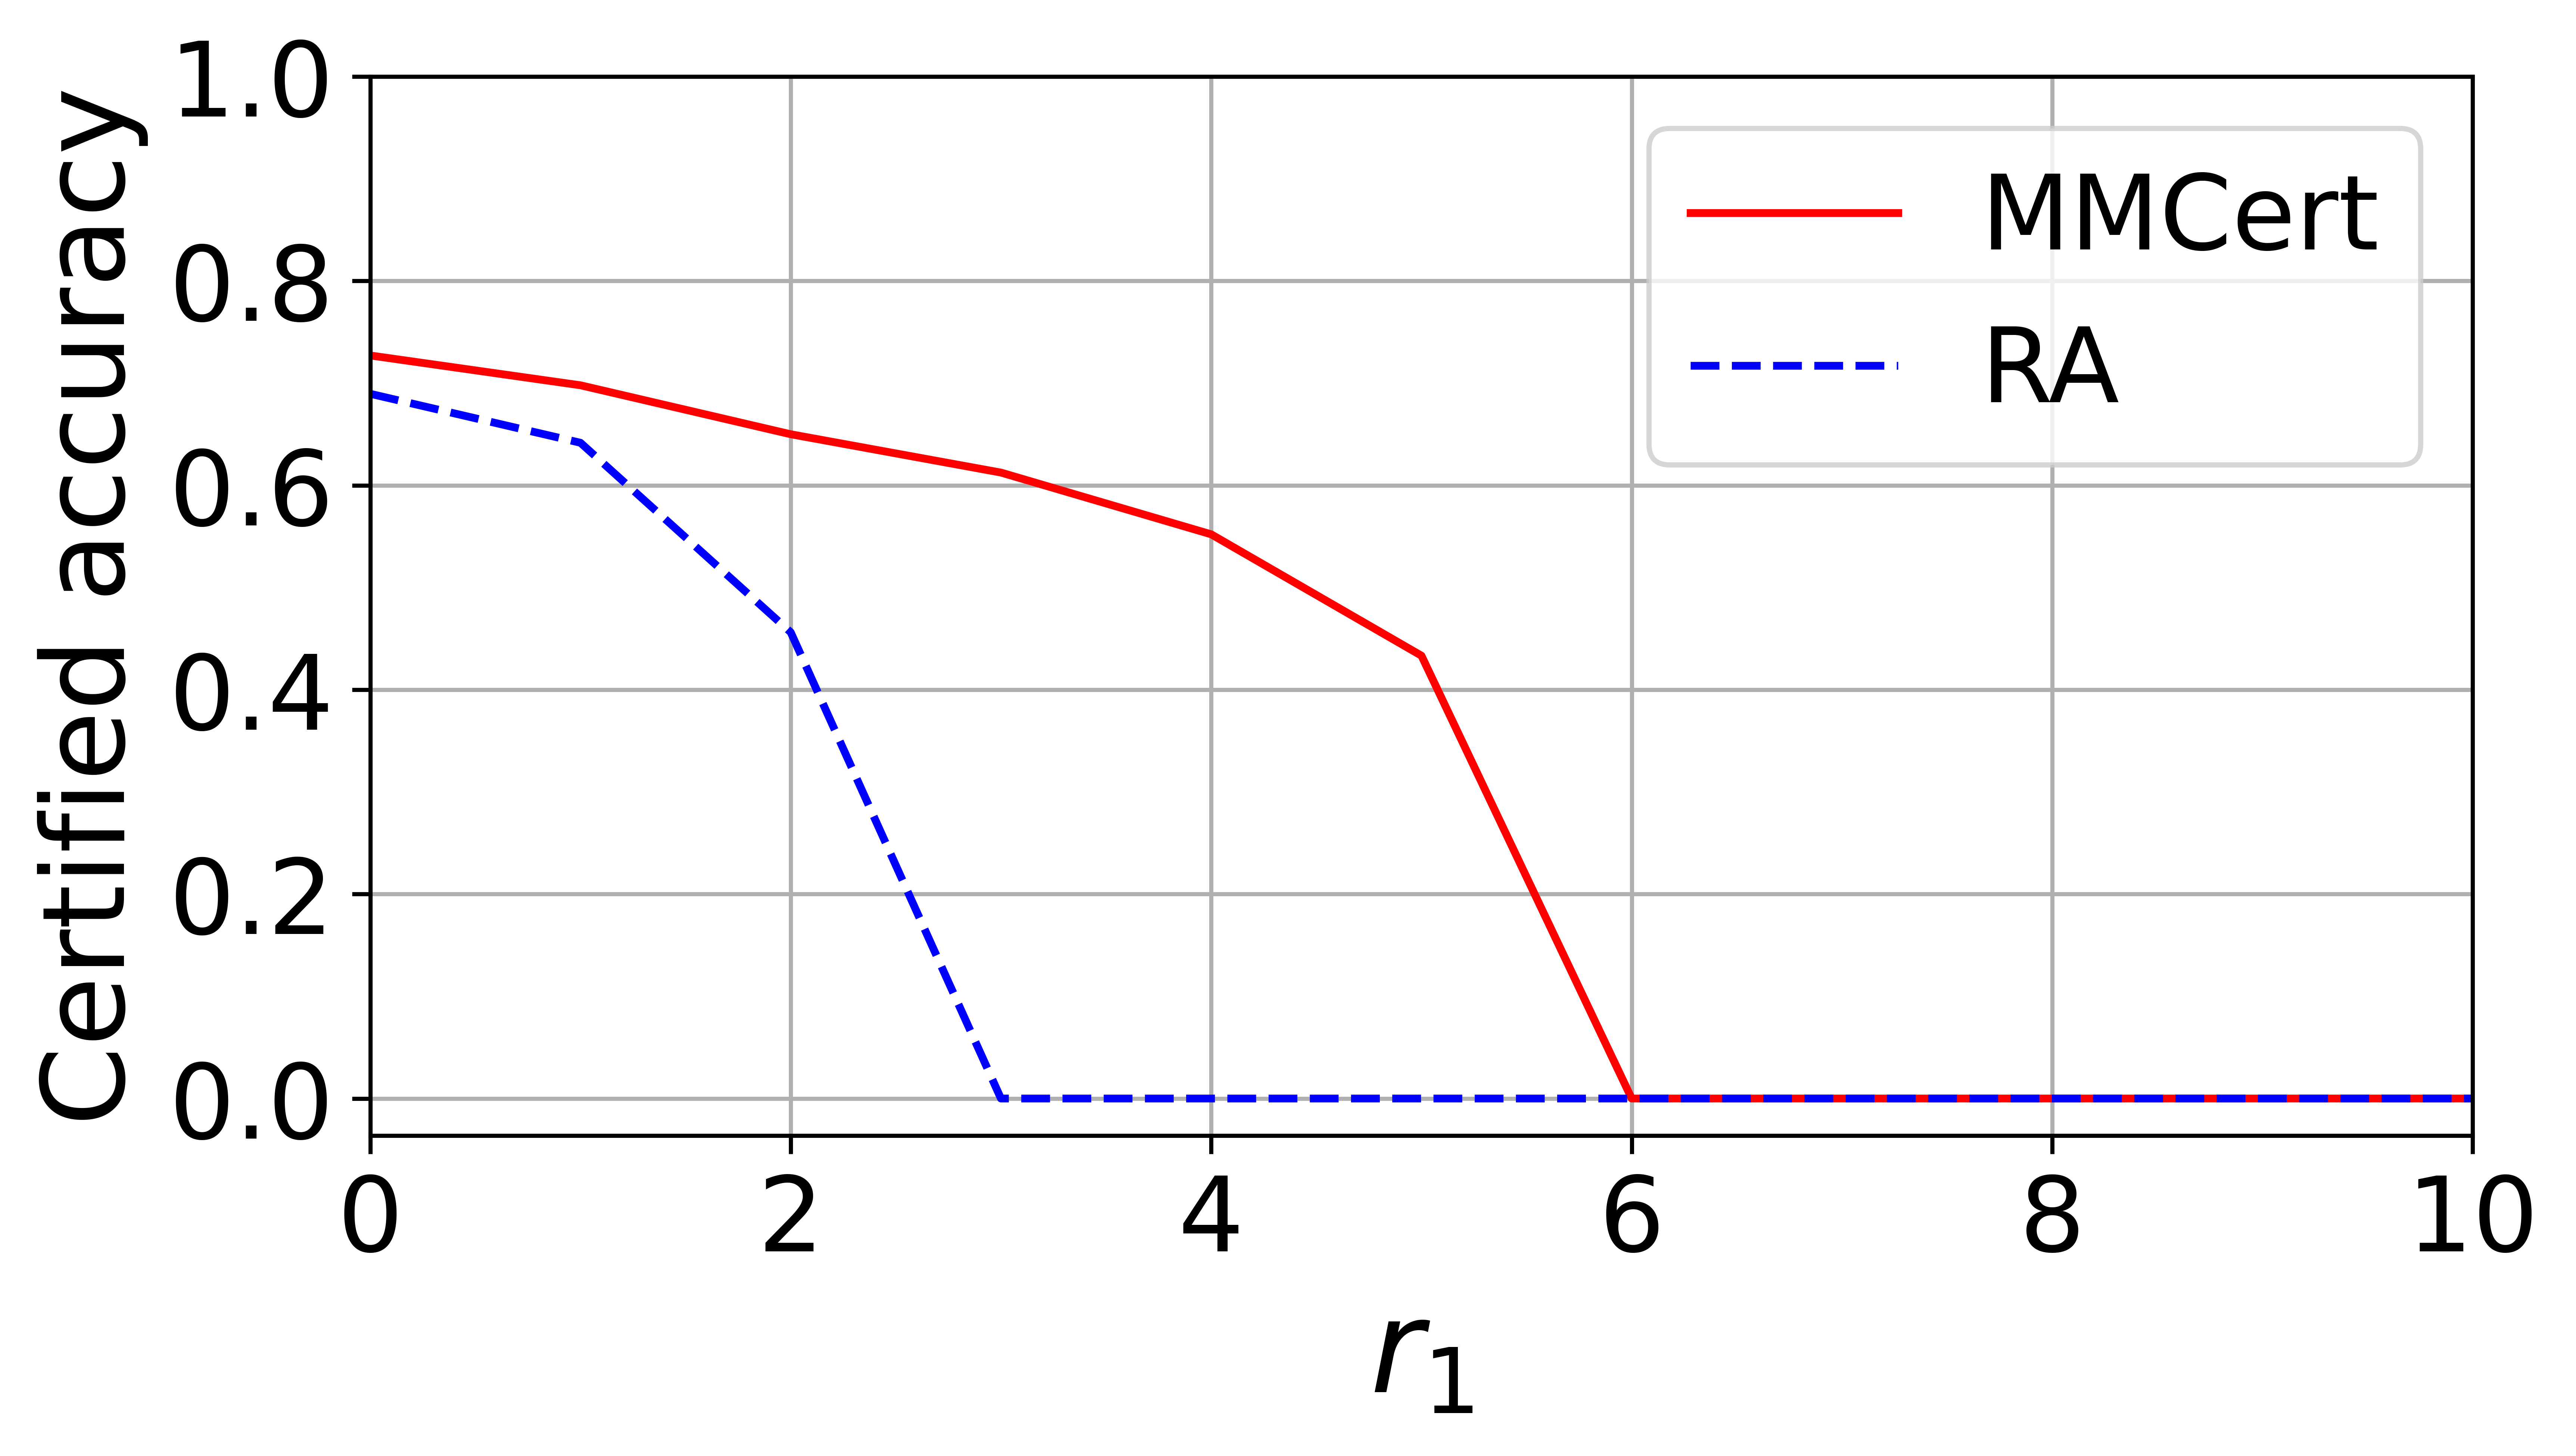

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import os,shutil,json
import argparse
from torch.autograd import Variable
from statsmodels.stats.proportion import proportion_confint
import glob
import os
import copy
from scipy.special import comb
parser = argparse.ArgumentParser()
parser.add_argument("-num_models", type=int, help="number of models per class", default=15)
parser.add_argument("-k", type=float, default=3000)#for randomized_ablation
parser.add_argument("-k1", type=float, default=5)#for MMCert
parser.add_argument("-k2", type=float, default=1000)#for MMCert
parser.add_argument("-r2_geq_r1", type=float, default=True)#for MMCert
parser.add_argument("-r1_r2_ratio", type=int, default=4)
parser.add_argument("-inverse_r1_r2_ratio", type=int, default=4)
parser.add_argument("-alpha", type=float, default=0.001)
parser.add_argument("-num_ablated_inputs", type=int, default=100)
parser.add_argument("-num_classes", type=int, default=8)
parser.add_argument("-c", type=int, default=480, help = "number of test samples")


def _lower_confidence_bound(NA: int, N: int, alpha: float) -> float:
        """ Returns a (1 - alpha) lower confidence bound on a bernoulli proportion.
        This function uses the Clopper-Pearson method.
        :param NA: the number of "successes"
        :param N: the number of total draws
        :param alpha: the confidence level
        :return: a lower bound on the binomial proportion which holds true w.p at least (1 - alpha) over the samples
        """
        return proportion_confint(NA, N, alpha, method="beta")
def get_bounds(args,counts):
    lower_bounds = np.zeros((args.c,args.num_classes))
    upper_bounds = np.zeros((args.c,args.num_classes))
    for i in range(args.c):
        for j in range(args.num_classes):
            lower_bounds[i][j],upper_bounds[i][j] = _lower_confidence_bound(counts[i][j], args.num_ablated_inputs, args.alpha/8)
    return lower_bounds, upper_bounds

def is_certified(true_label,lower_bounds,upper_bounds,e1,e2,n1,n2,k1,k2):
    #print(comb(5, 2, exact=True))
    lower_bounds = copy.deepcopy(lower_bounds)
    upper_bounds = copy.deepcopy(upper_bounds)
    delta = 1-((comb(e1,k1, exact=True)*comb(e2,k2, exact=True))/(comb(n1,k1, exact=True)*comb(n2,k2, exact=True)))
    #delta = 1-((e1/n1)**k1)*((e2/n2)**k2)
    #print(n1-e1,delta)
    lower_bounds -= delta
    upper_bounds += delta
    upper_bounds[true_label] = 0
    #print(n1-e1,delta, lower_bounds[true_label],np.max(upper_bounds))
    if lower_bounds[true_label]>np.max(upper_bounds):
        
        return True
    return False
def is_certified_baseline(true_label,lower_bounds,upper_bounds,e,n,k):
    #print(comb(5, 2, exact=True))
    lower_bounds = copy.deepcopy(lower_bounds)
    upper_bounds = copy.deepcopy(upper_bounds)
    delta = 1-((comb(e,k, exact=True))/(comb(n,k, exact=True)))
    #delta = 1-((e1+e2)/(n1+n2))**(k1+k2)
    #print(n1-e1,delta)
    lower_bounds -= delta
    upper_bounds += delta
    upper_bounds[true_label] = 0
    #print(n1-e1,delta, lower_bounds[true_label],np.max(upper_bounds))
    if lower_bounds[true_label]>0.5:
        return True
    return False

args = parser.parse_args([])
print("========MSCert=========")

all_outputs = torch.load('output/'+"MMCert_k1="+str(args.k1)+"_k2="+str(args.k2)+'_all_outputs.pth')

all_preds = torch.stack(all_outputs[0]).t()
all_targets=torch.stack(all_outputs[1]).t()
print(all_preds.shape,all_targets.shape)
n1 = 108
n2 = 79380
k1 = args.k1
k2 = args.k2

counts = np.zeros((all_targets.shape[0],args.num_classes))
for i in range(all_targets.shape[0]):
    for j in range(all_targets.shape[1]):
        counts[i][all_preds[i][j]] += 1
lower,upper = get_bounds(args, counts)
#lower = lower-(1/(n**m))
#upper = upper+(1/(n**m))
"""
for i in range(10):
    print(counts[i])
    print(lower[i])
    print(upper[i])
"""
rs = []
CAs = []
CAs_baseline = []
if args.r2_geq_r1 ==True:
    RANGE=11
else:
    RANGE=6
for r in range(RANGE):
    if args.r2_geq_r1 ==True:
        r1 = r
        r2 = args.r1_r2_ratio*r
    else:
        r2 = r
        r1 = args.inverse_r1_r2_ratio*r
    e1 = n1-r1
    e2 = n2-r2
    x = 0
    certified = 0
    for i in range(args.c):
        #print(r, get_V(targets[i],upper[i]),get_U(targets[i],lower[i]))
        if is_certified(all_targets[i][0],lower[i],upper[i],e1,e2,n1,n2,k1,k2) == True:
            certified+=1

    CAs.append(certified/args.c)
    rs.append(r)
    print(r,certified/args.c)
print("========Randomized_ablation=========")
#randomized_ablation  
all_outputs = torch.load('output/'+"randomized_ablation_k="+str(args.k)+'_all_outputs.pth')
all_preds = torch.stack(all_outputs[0]).t()
all_targets=torch.stack(all_outputs[1]).t()
#print(all_preds.shape,all_targets.shape)
n1 = 108
n2 = 79380
k = args.k

counts = np.zeros((all_targets.shape[0],args.num_classes))
for i in range(all_targets.shape[0]):
    for j in range(all_targets.shape[1]):
        counts[i][all_preds[i][j]] += 1
lower,upper = get_bounds(args, counts)
#lower = lower-(1/(n**m))
#upper = upper+(1/(n**m))
"""
for i in range(10):
    print(counts[i])
    print(lower[i])
    print(upper[i])
"""
rs = []
CAs_baseline = []
for r in range(RANGE):
    if args.r2_geq_r1 ==True:
        r1 = r
        r2 = args.r1_r2_ratio*r
    else:
        r2 = r
        r1 = args.inverse_r1_r2_ratio*r
    n = n1+n2
    e = n1+n2-r1-r2

    x = 0

    certified_baseline = 0

    for i in range(args.c):
        #print(r, get_V(targets[i],upper[i]),get_U(targets[i],lower[i]))
        if is_certified_baseline(all_targets[i][0],lower[i],upper[i],e,n,k) == True:
            certified_baseline+=1
    CAs_baseline.append(certified_baseline/args.c)
    rs.append(r)
    print(r,certified_baseline/args.c)
plt.figure(figsize = (7,4))

plt.plot( rs,CAs, label =  r'MMCert',color ="red")
#plt.plot( Ts,bagging_recalls, label = 'Bagging Recall',linestyle = '--',color ="b")
plt.plot( rs,CAs_baseline, label =  r'RA',linestyle = '--',color ="blue")

#plt.plot( Ts,dpa_ind_recalls, label = 'DPA Recall',linestyle = 'dotted',color ="b")
#plt.plot( Ts,dpa_ind_recalls, label = 'DPA',linestyle = 'dotted',color ="g")
#plt.plot( Ts,dpa_ind_precisions, label = 'DPA Precisions',linestyle = '-.',color ="r")
if args.r2_geq_r1 ==True:
    plt.xlabel(r'$r_1$', fontsize=25)
else:
    plt.xlabel(r'$r_2$', fontsize=25)
plt.ylabel('Certified accuracy', fontsize=22)
plt.grid()
plt.legend(loc='upper right',fontsize=20)
plt.xlim(0)
if args.r2_geq_r1 ==True:
    plt.xlim(xmax =6)
else:
    plt.xlim(xmax =5)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
#plt.xticks([0,10,20,30,40,50,60])
if args.r2_geq_r1 ==True:
    plt.xticks([0,2,4,6,8,10])
else:
    plt.xticks([0,1,2,3,4,5])

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.tight_layout()
plt.rcParams['figure.dpi'] = 1000
plt.tight_layout()
if args.r2_geq_r1 ==True:
    plt.savefig('figs/CA_r1-r2-ratio='+str(args.r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
else:
    plt.savefig('figs/CA_inverse-r1-r2-ratio='+str(args.inverse_r1_r2_ratio)+'.pdf', dpi=1000,bbox_inches='tight')
plt.rcParams['figure.dpi'] = 1000
plt.show()